<a href="https://colab.research.google.com/github/microprediction/monteprediction_colab_examples/blob/main/monteprediction_predict_o1_matrix_using_copulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Nigel's Marvellous Predict-o1-Matic Entry in www.MontePrediction.com

This notebook was created by Open AI's o1-Preview model with very minor corrections. For an explanation of the game including scoring mechanism and motivation see the original notebook [here](https://github.com/microprediction/monteprediction_colab_examples/blob/main/monteprediction_entry.ipynb). To create this example I merely asked it to look at this entry and create a stronger entry.

### O1's Strategy for Improving the Default Entry

*I enhanced the benchmark entry by first improving the covariance estimation. Instead of using the empirical covariance matrix, which can be unstable with limited data, I implemented the Ledoit-Wolf shrinkage estimator to obtain a more robust and efficient covariance matrix. This helps in better capturing the true relationships between the sectors.*

*Next, I addressed the modeling of marginal distributions. Financial returns often exhibit fat tails and skewness, so I fitted a Student's t-distribution to each sector's returns. This choice accommodates the heavy tails and provides a more accurate representation of the return distributions compared to the normal distribution.*

*To model the dependence structure between sectors more effectively, I utilized a Gaussian copula. This allows for the separation of marginal distributions from their dependencies, capturing non-linear relationships that simple correlation might miss. By transforming the data to uniform margins and applying the copula, we preserve the individual characteristics of each sector while accurately modeling their joint behavior.*

*I also enriched the dataset by calculating weekly returns from different starting days of the week (Tuesday-Tuesday, Wednesday-Wednesday, etc.). This increases the number of observations and reduces day-of-week biases, leading to more robust estimates of the marginal distributions and the covariance matrix.*


### Step 1: Import Necessary Libraries

In [1]:
!pip install yfinance
!pip install pandas
!pip install seaborn
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install statsmodels
!pip install copulas
!pip install monteprediction

import yfinance as yf
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
import time
from monteprediction import SPDR_ETFS
from monteprediction.calendarutil import get_last_wednesday
from monteprediction.submission import send_in_chunks

# For covariance estimation
from sklearn.covariance import LedoitWolf

# For marginal distribution fitting
from scipy.stats import t, norm

# For copulas
from copulas.multivariate import GaussianMultivariate, VineCopula

# For random number generation
from scipy.stats import qmc


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 1.5 MB/s eta 0:00:00


### Step 2: Define Tournament Settings

In [2]:
# Tournament settings, don't change these.
num_samples_per_chunk = int(1048576/8)
num_chunks = 8
num_samples = num_chunks * num_samples_per_chunk


### Step 3: Download Historical Weekly Returns

In [6]:
# Define the time period for historical data
num_weeks = 260  # 5 years of data
start_date = datetime.today() - timedelta(weeks=num_weeks)
end_date = datetime.today()

# Download daily adjusted close prices
data = yf.download(SPDR_ETFS, start=start_date, end=end_date, interval="1d")
daily_prices = data['Adj Close']

# Reset index to get dates as a column
daily_prices = daily_prices.reset_index()


# Initialize a list to store DataFrames of weekly returns
weekly_returns_list = []

# Loop over each day of the week (0=Monday, ..., 4=Friday)
for dow in range(0, 5):
    # Filter data for the specific day of the week
    dow_prices = daily_prices[daily_prices['Date'].dt.dayofweek == dow]

    # Ensure the data is sorted by date
    dow_prices = dow_prices.sort_values('Date')

    # Set 'Date' as index
    dow_prices = dow_prices.set_index('Date')

    # Calculate weekly returns (from one week to the next)
    dow_weekly_returns = dow_prices.pct_change().dropna()

    # Append the weekly returns DataFrame to the list
    weekly_returns_list.append(dow_weekly_returns)

# Concatenate all weekly returns DataFrames into one DataFrame
weekly_returns = pd.concat(weekly_returns_list, ignore_index=True)



[*********************100%***********************]  11 of 11 completed


### Step 4: Fit Marginal Distributions

In [7]:
# Fit t-distribution to each sector
marginal_params = {}
for sector in SPDR_ETFS:
    sector_returns = weekly_returns[sector]
    params = t.fit(sector_returns)
    marginal_params[sector] = params


# Step 5: Estimate the Covariance Matrix Using Ledoit-Wolf

In [18]:
# Estimate covariance matrix using Ledoit-Wolf shrinkage
lw = LedoitWolf().fit(weekly_returns)
cov_matrix = lw.covariance_

uniform_margins = pd.DataFrame()
for sector in SPDR_ETFS:
    params = marginal_params[sector]
    cdf_values = t.cdf(weekly_returns[sector], df=params[0], loc=params[1], scale=params[2])
    uniform_margins[sector] = cdf_values

# Compute the correlation matrix of the uniform margins
corr_matrix = uniform_margins.corr()
corr_matrix


,XLB,XLC,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV,XLY
XLB,1.000000,0.552739,0.567164,0.789929,0.854186,0.545678,0.536365,0.596141,0.469294,0.556825,0.641790
XLC,0.552739,1.000000,0.286723,0.554211,0.601080,0.789047,0.414908,0.509596,0.311900,0.496437,0.732737
XLE,0.567164,0.286723,1.000000,0.587679,0.549107,0.177717,0.204759,0.249063,0.204584,0.234875,0.269733
XLF,0.789929,0.554211,0.587679,1.000000,0.848962,0.501632,0.510377,0.564938,0.436003,0.526988,0.633593
XLI,0.854186,0.601080,0.549107,0.848962,1.000000,0.613091,0.536575,0.633049,0.453004,0.547479,0.698677
XLK,0.545678,0.789047,0.177717,0.501632,0.613091,1.000000,0.410290,0.539634,0.294537,0.516660,0.797461
XLP,0.536365,0.414908,0.204759,0.510377,0.536575,0.410290,1.000000,0.604809,0.640798,0.653042,0.472830
XLRE,0.596141,0.509596,0.249063,0.564938,0.633049,0.539634,0.604809,1.000000,0.697928,0.598019,0.607177
XLU,0.469294,0.311900,0.204584,0.436003,0.453004,0.294537,0.640798,0.697928,1.000000,0.582702,0.379248
XLV,0.556825,0.496437,0.234875,0.526988,0.547479,0.516660,0.653042,0.598019,0.582702,1.000000,0.518699


### Step 6: Construct the Copula Model
We'll use a Gaussian copula for simplicity. Alternatively, you can use Vine copulas for more flexibility.

In [19]:
# 6.1 Generate base uniform samples using Sobol sequence
sampler = qmc.Sobol(d=len(SPDR_ETFS), scramble=True)
uniform_samples = sampler.random_base2(m=int(np.log2(num_samples)))

# Convert uniform_samples to a DataFrame with sector names as columns
uniform_samples = pd.DataFrame(uniform_samples, columns=SPDR_ETFS)

# 6.2 Convert uniform samples to standard normal quantiles
standard_normals = norm.ppf(uniform_samples)

# 6.3 Apply the Cholesky decomposition to the correlation matrix
L = cholesky(corr_matrix, lower=True)

# 6.4 Generate correlated standard normals
correlated_normals = standard_normals.dot(L.T)

# 6.5 Convert the correlated normals back to uniform variables
correlated_uniforms = norm.cdf(correlated_normals)

# 6.6 Convert correlated_uniforms to a DataFrame with sector names as columns
correlated_uniforms = pd.DataFrame(correlated_uniforms, columns=SPDR_ETFS)


# Initialize the samples DataFrame
samples = pd.DataFrame(columns=SPDR_ETFS)

# Transform each sector back using the inverse CDF of the fitted t-distribution
for sector in SPDR_ETFS:
    params = marginal_params[sector]
    samples[sector] = t.ppf(correlated_uniforms[sector], df=params[0], loc=params[1], scale=params[2])

### Step 7: Transform back to original space

In [22]:

# Initialize the samples DataFrame
samples = pd.DataFrame(columns=SPDR_ETFS)

# Transform each sector back using the inverse CDF of the fitted t-distribution
for sector in SPDR_ETFS:
    params = marginal_params[sector]
    samples[sector] = t.ppf(correlated_uniforms[sector], df=params[0], loc=params[1], scale=params[2])

### Step 8: Clean and Verify the Samples

In [23]:
# Replace any infinite or NaN values resulting from extreme quantiles
samples.replace([np.inf, -np.inf], np.nan, inplace=True)
samples.fillna(samples.mean(), inplace=True)

# Verify submission
assert len(samples.index) == num_samples, f'Expecting exactly {num_samples} samples'
assert list(samples.columns) == SPDR_ETFS, 'Columns should match SPDR_ETFS in order'


# Step 9: Submit the DataFrame

In [25]:
YOUR_EMAIL = 'putyouremailhere@crunchdao.com'  # Change this to your email
YOUR_NAME = 'Predict-o1-Matic'                 # Your name or handle you want for the leaderboard

response = send_in_chunks(samples, num_chunks=num_chunks, email=YOUR_EMAIL, name=YOUR_NAME)
print(response)


Chunk 0 of 8 sent successfully.
Chunk 1 of 8 sent successfully.
Chunk 2 of 8 sent successfully.
Chunk 3 of 8 sent successfully.
Chunk 4 of 8 sent successfully.
Chunk 5 of 8 sent successfully.
Chunk 6 of 8 sent successfully.
Chunk 7 of 8 sent successfully.
{'expiry': '2024_09_30', 'message': 'Submission from nigel.grant@crunchdao.com received for week concluding 2024_09_30', 'name': 'Predict-o1-Matic'}


# O1's Suggestions for Future Improvements


*Incorporate advanced generative models such as Variational Autoencoders (VAEs) or Generative Adversarial Networks (GANs) to model the complex distribution of sector returns.

*Utilize time-series neural networks like Long Short-Term Memory (LSTM) or Transformer models to capture temporal dependencies in the data.

*Implement regime-switching models to account for different market conditions, allowing the model to adapt to bull and bear markets.

*Explore non-parametric methods like kernel density estimation to model the marginal distributions without assuming a specific parametric form.

*Employ ensemble techniques by combining multiple models, such as blending copula-based models with machine learning predictors, to improve overall performance.

*Integrate alternative data sources, including macroeconomic indicators, sentiment analysis from news articles, or social media trends, to enrich the feature set.

*Apply dimensionality reduction methods like Principal Component Analysis (PCA) or t-Distributed Stochastic Neighbor Embedding (t-SNE) to identify underlying factors affecting sector movements.

*Experiment with different copula families, such as t-copulas or Archimedean copulas, to better capture tail dependencies between sectors.

*Use bootstrap aggregating (bagging) techniques to improve the stability and robustness of predictions by averaging over multiple resampled datasets.

*Incorporate Bayesian inference to update model parameters as new data becomes available, allowing for a probabilistic interpretation of predictions.

*Implement stochastic volatility models to account for time-varying volatility and enhance the modeling of return distributions.

*Leverage reinforcement learning to develop adaptive strategies that can learn optimal actions based on reward signals from market performance.

*Consider hierarchical models that can capture dependencies at multiple levels, such as individual sectors and the overall market index.

*Utilize quantile regression to model different parts of the return distribution, providing insights into potential risks and extreme events.

*Adopt robust optimization techniques to make the model less sensitive to outliers and noise in the data.

*Integrate cross-validation and hyperparameter tuning systematically to optimize model performance and prevent overfitting.

*Explore the use of transfer learning by leveraging models trained on related financial tasks to improve prediction accuracy.

*Implement feature selection algorithms to identify the most predictive variables, reducing complexity and enhancing model interpretability.

*Apply clustering algorithms to segment periods with similar market characteristics, allowing for tailored modeling approaches in each cluster.

*Use multi-task learning to simultaneously predict returns for multiple sectors, exploiting shared information and improving generalization.

### A little more explanation of the Copula approach

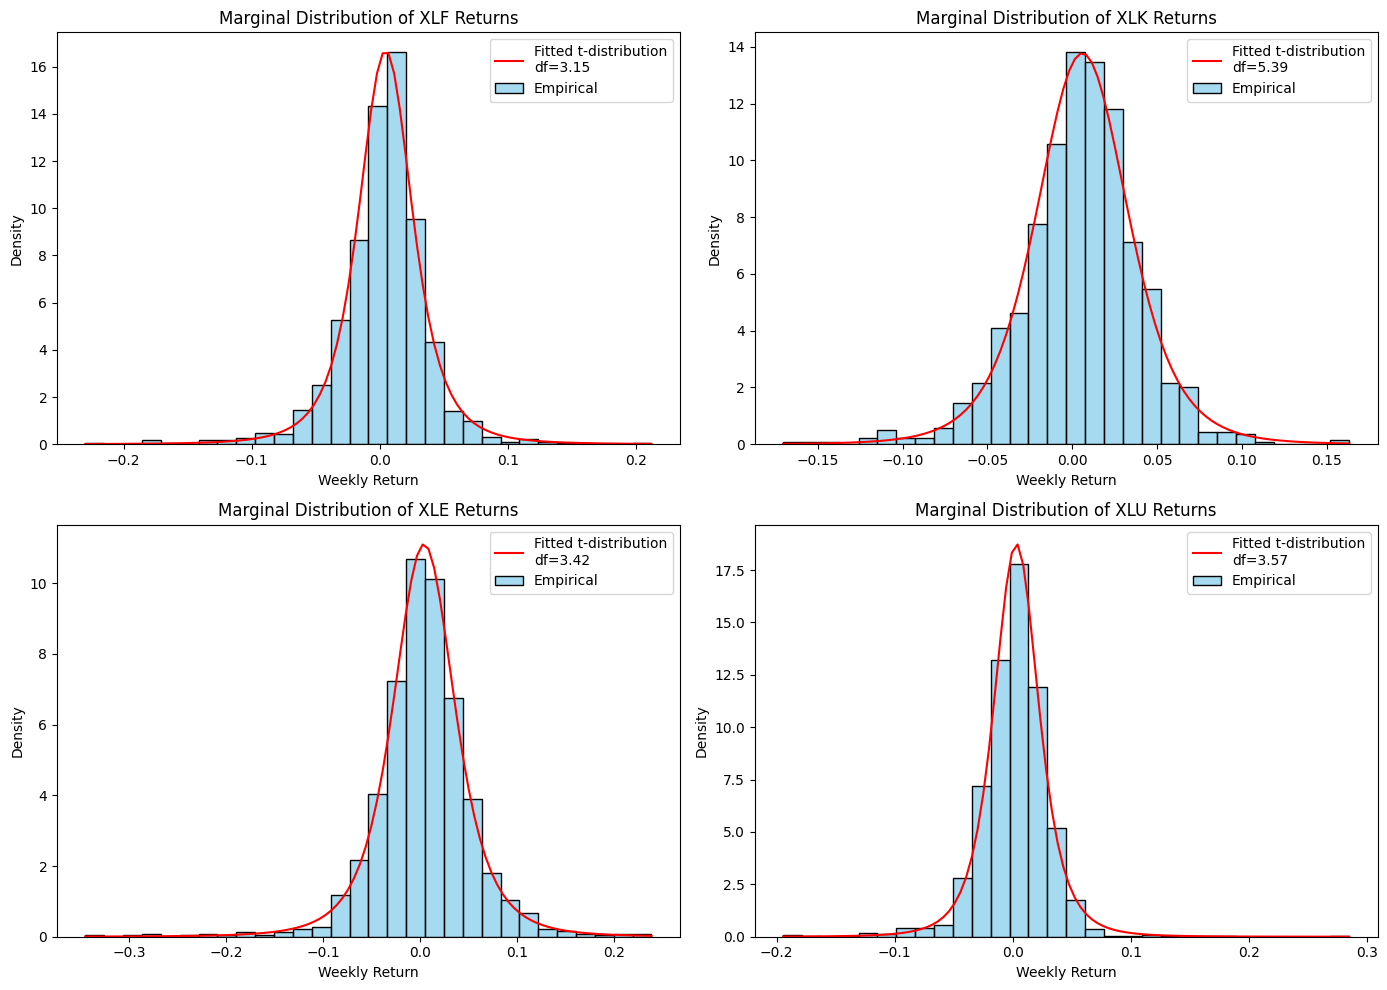

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import t

# Select a few sectors to plot
sectors_to_plot = ['XLF', 'XLK', 'XLE', 'XLU']

# Set up the figure
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

for i, sector in enumerate(sectors_to_plot):
    # Get the empirical returns
    sector_returns = weekly_returns_combined[sector]

    # Get the fitted parameters
    params = marginal_params[sector]
    df_param, loc_param, scale_param = params

    # Create a range of values for the fitted distribution
    x = np.linspace(sector_returns.min(), sector_returns.max(), 100)
    fitted_pdf = t.pdf(x, df=df_param, loc=loc_param, scale=scale_param)

    # Plot histogram of returns
    sns.histplot(sector_returns, bins=30, kde=False, stat='density', ax=axs[i], color='skyblue', label='Empirical')

    # Plot the fitted t-distribution
    axs[i].plot(x, fitted_pdf, 'r-', label=f"Fitted t-distribution\ndf={df_param:.2f}")

    # Set titles and labels
    axs[i].set_title(f"Marginal Distribution of {sector} Returns")
    axs[i].set_xlabel('Weekly Return')
    axs[i].set_ylabel('Density')
    axs[i].legend()

plt.tight_layout()
plt.show()


Now we look at the actual bivate distribution...


Correlation coefficient between XLF and XLK: 0.5016


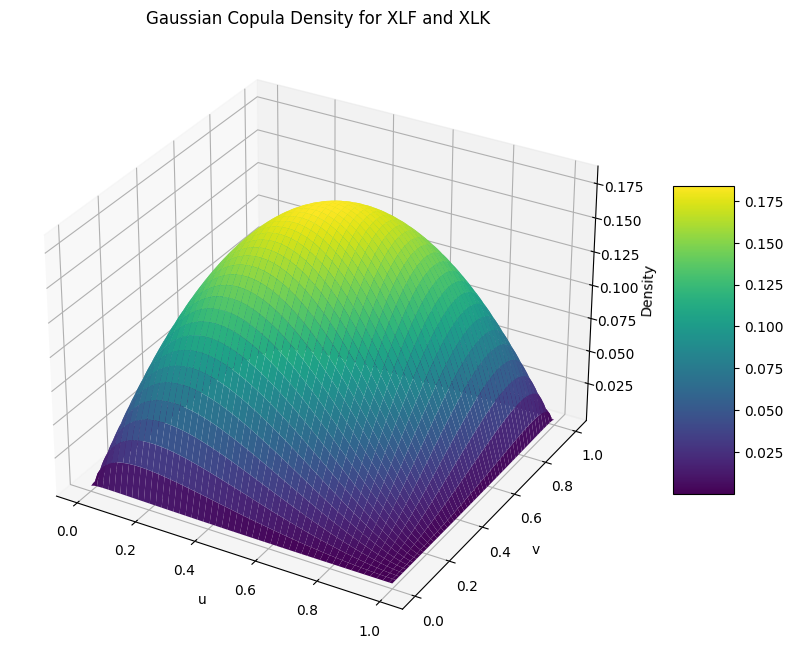

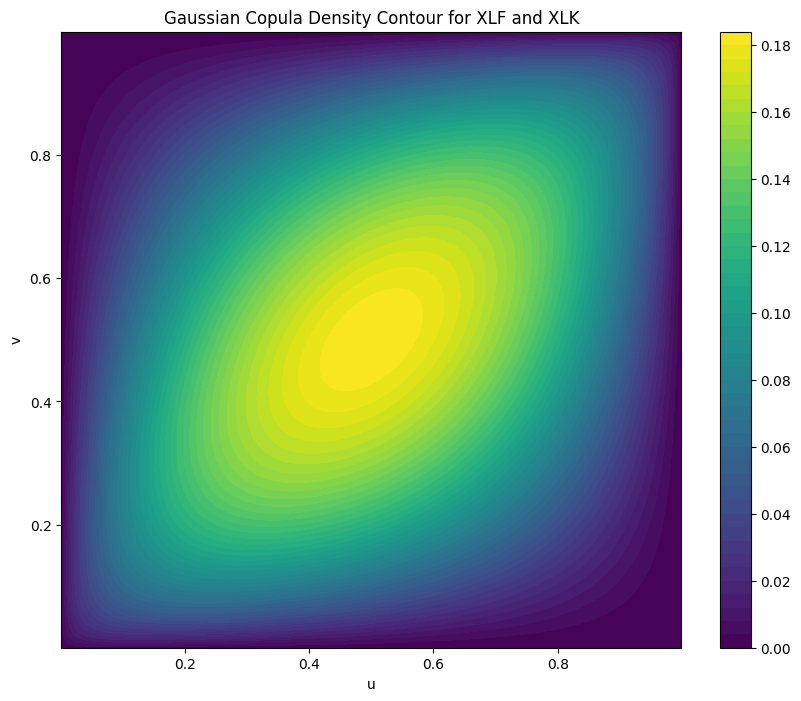

In [27]:
# Select sectors
sector_x = 'XLF'
sector_y = 'XLK'

# Extract the correlation coefficient from the copula correlation matrix
rho = corr_matrix.loc[sector_x, sector_y]
print(f"Correlation coefficient between {sector_x} and {sector_y}: {rho:.4f}")
from scipy.stats import norm

def gaussian_copula_density(u, v, rho):
    # Convert u and v to standard normal quantiles
    z_u = norm.ppf(u)
    z_v = norm.ppf(v)

    # Compute the copula density
    numerator = np.exp(- (z_u**2 - 2 * rho * z_u * z_v + z_v**2) / (2 * (1 - rho**2)))
    denominator = 2 * np.pi * np.sqrt(1 - rho**2)
    density = numerator / denominator

    return density

# Create a grid of u and v values
u = np.linspace(0.001, 0.999, 100)  # Avoid 0 and 1 to prevent infinite quantiles
v = np.linspace(0.001, 0.999, 100)
U, V = np.meshgrid(u, v)

# Compute the copula density over the grid
C = gaussian_copula_density(U, V, rho)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(U, V, C, cmap='viridis', edgecolor='none')

# Customize the plot
ax.set_title(f"Gaussian Copula Density for {sector_x} and {sector_y}")
ax.set_xlabel('u')
ax.set_ylabel('v')
ax.set_zlabel('Density')

# Add a color bar
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# Create the figure
plt.figure(figsize=(10, 8))

# Plot the contour
contour = plt.contourf(U, V, C, levels=50, cmap='viridis')

# Customize the plot
plt.title(f"Gaussian Copula Density Contour for {sector_x} and {sector_y}")
plt.xlabel('u')
plt.ylabel('v')

# Add a color bar
plt.colorbar(contour)

plt.show()
